In [64]:
import tensorflow as tf
import os


In [65]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

[]


In [66]:
import cv2
import imghdr
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.applications import VGG16

In [67]:
img = cv2.imread(os.path.join('data', 'FAKE', '1000 (2).jpg'))

In [68]:
img.shape

(32, 32, 3)

In [69]:
Image_size = [32,32]

### Loading the data

In [70]:
data = tf.keras.utils.image_dataset_from_directory('data', image_size=(32, 32))

Found 100000 files belonging to 2 classes.


In [30]:
#resized_data = data.map(lambda x, y:(tf.image.resize(x,(224,224)), y))

In [71]:
data_it = data.as_numpy_iterator()

In [72]:
batch = data_it.next()

In [73]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


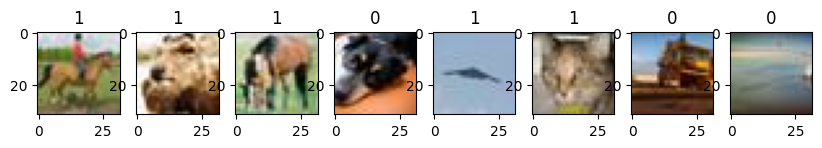

In [74]:
fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

### Preprocessing

In [75]:
print(batch[0].min())
print(batch[0].max())

0.0
255.0


Scaling the data between 0 and 1

In [76]:
data = data.map(lambda x, y : (x/255, y))

In [77]:
scaled_it = data.as_numpy_iterator()

In [78]:
batch = scaled_it.next()

In [79]:
print(batch[0].min())
print(batch[0].max())

0.0
1.0


Splitting the data into training, cross-validation and testing sets

In [47]:
len(data)

3125

In [80]:
train_size = int(len(data)*0.7)
cv_size = int(len(data)*0.2)
test_size = int(len(data)*0.1)+1

In [81]:
train_size+cv_size+test_size

3125

In [82]:
train = data.take(train_size)
cv = data.skip(train_size).take(cv_size)
test = data.skip(train_size+cv_size).take(test_size)

In [83]:
len(train)+len(cv)+len(test)

3125

### Building the DL Model

In [104]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Input, Lambda, Dense, Flatten, Dropout
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [85]:
model = Sequential()

In [86]:
# model.add(Conv2D(16, (4, 4), 1, activation='relu', input_shape=(32, 32, 3)))
# model.add(MaxPooling2D())

# model.add(Conv2D(32, (4, 4), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Conv2D(16, (4, 4), 1, activation='relu'))
# model.add(MaxPooling2D())

# model.add(Flatten())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(1, activation='sigmoid'))


model.add(Conv2D(80, (3, 3), strides = (1,1), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Conv2D(40, (3, 3), strides = (1,1), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(20, (3, 3), strides = (1,1), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [87]:
model.compile('adam', loss = tf.losses.binary_crossentropy, metrics=['accuracy'])

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 80)        2240      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 80)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 40)        28840     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 40)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 20)          7220      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 20)         

In [235]:
logdir = 'logs'

In [236]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [237]:
hist = model.fit(train, epochs=20, validation_data=cv, callbacks=[tensorboard_callback])

Epoch 1/20
2187/2187 [==============================] - 77s 35ms/step - loss: 0.4120 - accuracy: 0.8106 - val_loss: 0.3096 - val_accuracy: 0.8666
Epoch 2/20
2187/2187 [==============================] - 76s 35ms/step - loss: 0.2984 - accuracy: 0.8738 - val_loss: 0.2723 - val_accuracy: 0.8838
Epoch 3/20
2187/2187 [==============================] - 75s 34ms/step - loss: 0.2574 - accuracy: 0.8931 - val_loss: 0.2290 - val_accuracy: 0.9074
Epoch 4/20
2187/2187 [==============================] - 75s 34ms/step - loss: 0.2331 - accuracy: 0.9055 - val_loss: 0.2138 - val_accuracy: 0.9142
Epoch 5/20
2187/2187 [==============================] - 77s 35ms/step - loss: 0.2183 - accuracy: 0.9126 - val_loss: 0.2008 - val_accuracy: 0.9210
Epoch 6/20
2187/2187 [==============================] - 77s 35ms/step - loss: 0.2027 - accuracy: 0.9180 - val_loss: 0.1917 - val_accuracy: 0.9240
Epoch 7/20
2187/2187 [==============================] - 76s 35ms/step - loss: 0.1904 - accuracy: 0.9239 - val_loss: 0.1883 -

### Performance

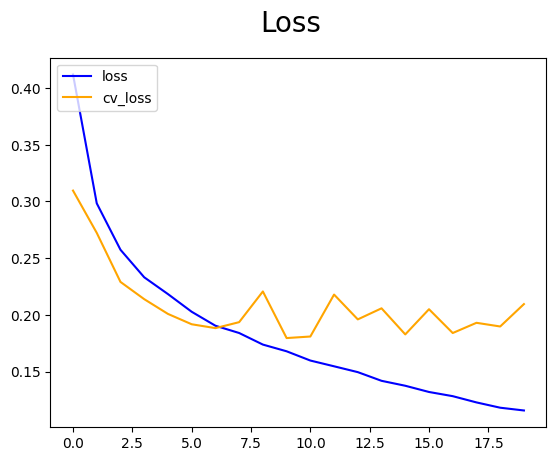

In [238]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='cv_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

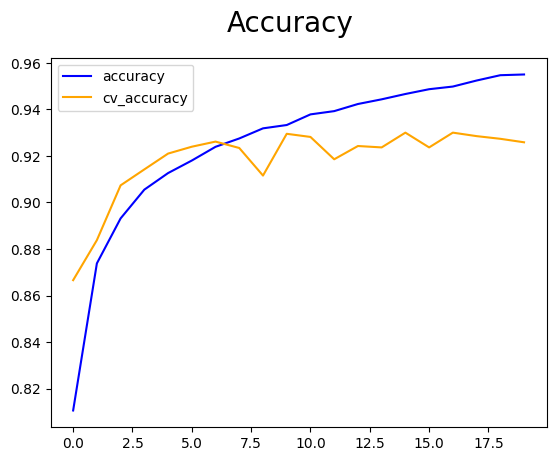

In [239]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='cv_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [240]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [241]:
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

In [242]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    # print("Shape of y:", y.shape)
    # print("Shape of yhat:", yhat.shape)

    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 29ms/step


In [243]:
print(f'Precision: {pre.result().numpy()}, Recall: {rec.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9461653232574463, Recall: 0.9003862738609314, Accuracy: 0.9259185194969177


In [244]:
from tensorflow.keras.models import load_model

In [245]:
model.save(os.path.join('model','airealimageclassifier.h5'))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [246]:
model = load_model(os.path.join('model','airealimageclassifier.h5'))

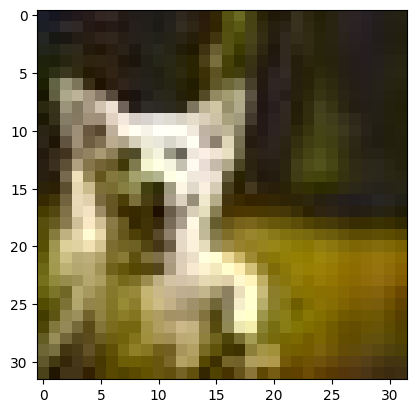

In [247]:
img = cv2.imread('ai1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [248]:
resize = tf.image.resize(img, (32, 32))

In [250]:
y_pred = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 15ms/step


In [251]:
y_pred

array([[5.6057347e-06]], dtype=float32)

In [252]:
if y_pred > 0.5: 
    print(f'Predicted class: REAL')
else:
    print(f'Predicted class: AI')

Predicted class: AI


313/313 [==============================] - 8s 11ms/step


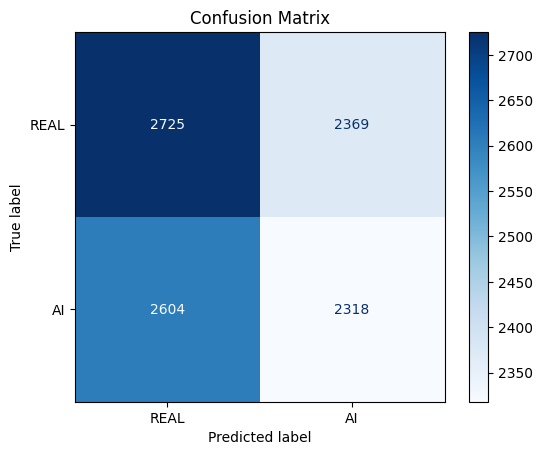

In [253]:
y_true = np.concatenate([y for x, y in test], axis=0)
y_pred_prob = model.predict(test)
y_pred = (y_pred_prob > 0.5).astype(int)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import confusion_matrix
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'AI'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.show()

In [255]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is your defined model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Resnet Model

In [108]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))


In [109]:
resnet_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_20 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1)                 513       
                                                                 
Total params: 24637313 (93.98 MB)
Trainable params: 1049601 (4.00 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [110]:
resnet_model.compile('adam', loss = tf.losses.binary_crossentropy, metrics=['accuracy'])

In [119]:
epochs=20
history_resnet50 = resnet_model.fit(
  train,
  validation_data=cv,
  epochs=epochs
)

Epoch 1/20
2187/2187 [==============================] - 243s 111ms/step - loss: 0.6507 - accuracy: 0.6166 - val_loss: 0.6390 - val_accuracy: 0.6583
Epoch 2/20
2187/2187 [==============================] - 236s 108ms/step - loss: 0.6365 - accuracy: 0.6342 - val_loss: 0.6196 - val_accuracy: 0.6914
Epoch 3/20
2187/2187 [==============================] - 237s 108ms/step - loss: 0.6270 - accuracy: 0.6481 - val_loss: 0.5982 - val_accuracy: 0.6945
Epoch 4/20
2187/2187 [==============================] - 233s 106ms/step - loss: 0.6256 - accuracy: 0.6454 - val_loss: 0.6097 - val_accuracy: 0.6928
Epoch 5/20
2187/2187 [==============================] - 223s 102ms/step - loss: 0.6184 - accuracy: 0.6587 - val_loss: 0.6107 - val_accuracy: 0.7017
Epoch 6/20
2187/2187 [==============================] - 238s 109ms/step - loss: 0.6161 - accuracy: 0.6609 - val_loss: 0.5938 - val_accuracy: 0.6837
Epoch 7/20
2187/2187 [==============================] - 238s 109ms/step - loss: 0.6145 - accuracy: 0.6641 - val_

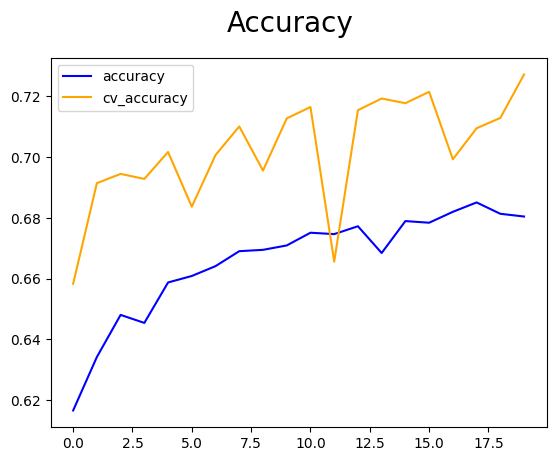

In [120]:
fig = plt.figure()
plt.plot(history_resnet50.history['accuracy'], color='blue', label='accuracy')
plt.plot(history_resnet50.history['val_accuracy'], color='orange', label='cv_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

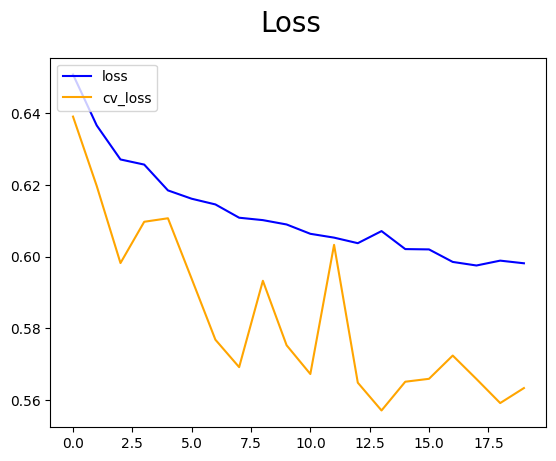

In [125]:
fig = plt.figure()
plt.plot(history_resnet50.history['loss'], color='blue', label='loss')
plt.plot(history_resnet50.history['val_loss'], color='orange', label='cv_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

VGG NET MODEl

In [52]:
vgg = VGG16(input_shape= Image_size + [3], weights='imagenet', include_top=False)

In [53]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
prediction = Dense(len(folders), activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

In [97]:
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from sklearn.metrics import classification_report

In [99]:
def create_model(pretrained_model):
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Freeze pretrained layers
    for layer in pretrained_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Load pretrained models
vgg16_model = create_model(VGG16(include_top=False, input_shape=(32, 32, 3), weights='imagenet'))
vgg19_model = create_model(VGG19(include_top=False, input_shape=(32, 32, 3), weights='imagenet'))


# Train each model
epochs = 20
history_vgg16 = vgg16_model.fit(train, validation_data=cv, epochs=epochs)
history_vgg19 = vgg19_model.fit(train, validation_data=cv, epochs=epochs)


# Make predictions and generate classification reports
models = {'VGG16': vgg16_model, 'VGG19': vgg19_model}
for model_name, model in models.items():
    print(f"Classification Report for {model_name}:")
    y_pred = model.predict(test)
    y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
    print(classification_report(y_test, y_pred_classes))

Epoch 1/20
2187/2187 [==============================] - 491s 224ms/step - loss: 0.3744 - accuracy: 0.8328 - val_loss: 0.3337 - val_accuracy: 0.8540
Epoch 2/20
2187/2187 [==============================] - 495s 226ms/step - loss: 0.3090 - accuracy: 0.8667 - val_loss: 0.3058 - val_accuracy: 0.8697
Epoch 3/20
2187/2187 [==============================] - 511s 234ms/step - loss: 0.2786 - accuracy: 0.8826 - val_loss: 0.3098 - val_accuracy: 0.8691
Epoch 4/20
2187/2187 [==============================] - 660s 302ms/step - loss: 0.2570 - accuracy: 0.8932 - val_loss: 0.2894 - val_accuracy: 0.8791
Epoch 5/20
2187/2187 [==============================] - 516s 236ms/step - loss: 0.2390 - accuracy: 0.9009 - val_loss: 0.2882 - val_accuracy: 0.8813
Epoch 6/20
2187/2187 [==============================] - 510s 233ms/step - loss: 0.2230 - accuracy: 0.9081 - val_loss: 0.2849 - val_accuracy: 0.8820
Epoch 7/20
2187/2187 [==============================] - 480s 220ms/step - loss: 0.2069 - accuracy: 0.9162 - val_

NameError: name 'y_test' is not defined

In [101]:
test_labels = []
for _, labels in test.as_numpy_iterator():
    test_labels.extend(labels)

In [102]:
models = {'VGG16': vgg16_model, 'VGG19': vgg19_model}
for model_name, model in models.items():
    print(f"Classification Report for {model_name}:")
    y_pred = model.predict(test)
    y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
    print(classification_report(test_labels, y_pred_classes))

Classification Report for VGG16:
313/313 [==============================] - 57s 173ms/step
              precision    recall  f1-score   support

           0       0.51      0.53      0.52      5060
           1       0.50      0.47      0.48      4956

    accuracy                           0.50     10016
   macro avg       0.50      0.50      0.50     10016
weighted avg       0.50      0.50      0.50     10016

Classification Report for VGG19:
313/313 [==============================] - 73s 221ms/step
              precision    recall  f1-score   support

           0       0.52      0.50      0.51      5060
           1       0.51      0.53      0.52      4956

    accuracy                           0.51     10016
   macro avg       0.51      0.51      0.51     10016
weighted avg       0.51      0.51      0.51     10016



In [126]:
models = {'RESNET50': resnet_model, 'MODEL': model}
for model_name, model in models.items():
    print(f"Classification Report for {model_name}:")
    y_pred = model.predict(test)
    y_pred_classes = (y_pred > 0.5).astype(int).reshape(-1)
    print(classification_report(test_labels, y_pred_classes))

Classification Report for RESNET50:
313/313 [==============================] - 31s 84ms/step
              precision    recall  f1-score   support

           0       0.51      0.48      0.49      5060
           1       0.50      0.53      0.52      4956

    accuracy                           0.50     10016
   macro avg       0.51      0.51      0.50     10016
weighted avg       0.51      0.50      0.50     10016

Classification Report for MODEL:
313/313 [==============================] - 75s 226ms/step
              precision    recall  f1-score   support

           0       0.50      0.48      0.49      5060
           1       0.49      0.51      0.50      4956

    accuracy                           0.50     10016
   macro avg       0.50      0.50      0.50     10016
weighted avg       0.50      0.50      0.50     10016



In [127]:
from tensorflow.keras.models import load_model
vgg16_model.save(os.path.join('model','vgg16_model_airealimageclassifier.h5'))
vgg19_model.save(os.path.join('model','vgg19_model_airealimageclassifier.h5'))
resnet_model.save(os.path.join('model','resnet50_model_airealimageclassifier'))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: model/resnet50_model_airealimageclassifier/assets


INFO:tensorflow:Assets written to: model/resnet50_model_airealimageclassifier/assets


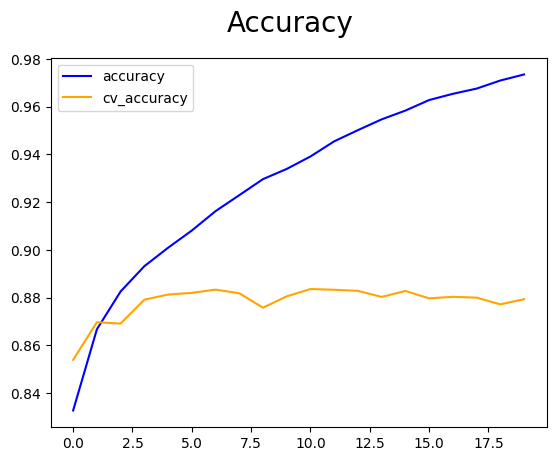

In [114]:
fig = plt.figure()
plt.plot(history_vgg16.history['accuracy'], color='blue', label='accuracy')
plt.plot(history_vgg16.history['val_accuracy'], color='orange', label='cv_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

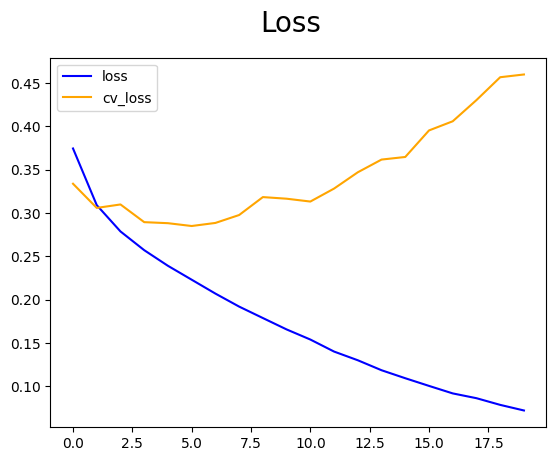

In [115]:
fig = plt.figure()
plt.plot(history_vgg16.history['loss'], color='blue', label='loss')
plt.plot(history_vgg16.history['val_loss'], color='orange', label='cv_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

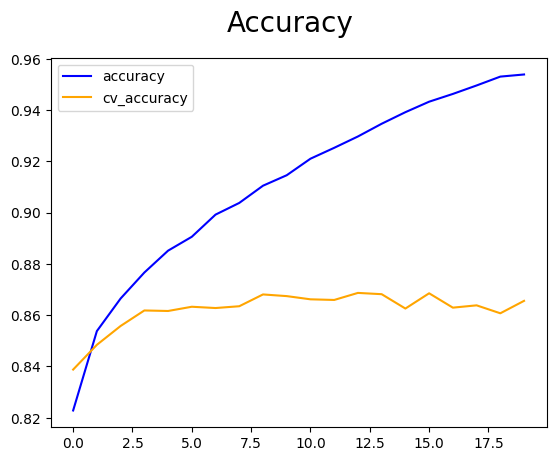

In [116]:
fig = plt.figure()
plt.plot(history_vgg19.history['accuracy'], color='blue', label='accuracy')
plt.plot(history_vgg19.history['val_accuracy'], color='orange', label='cv_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

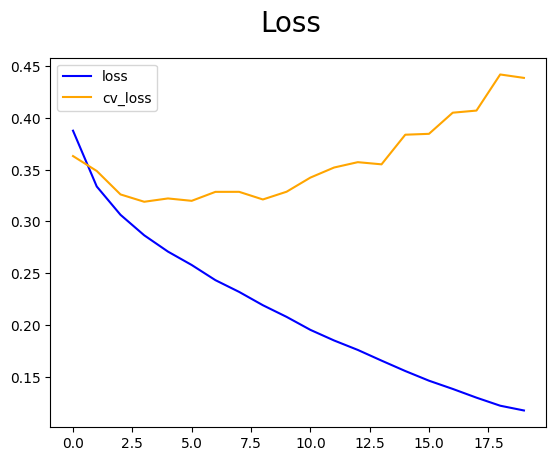

In [117]:
fig = plt.figure()
plt.plot(history_vgg19.history['loss'], color='blue', label='loss')
plt.plot(history_vgg19.history['val_loss'], color='orange', label='cv_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()